## Scipy Optimize Workshop @ UCD Data Science Initiative
### February 19, 2016

# Introduction to Models

In [2]:
import sys
sys.executable

'/Users/emilyhalket/anaconda/envs/py35/bin/python'

In [3]:
from matplotlib import mlab
ortho = mlab.csv2rec('./scipy-optimize-data/ortho.csv')
para = mlab.csv2rec('./scipy-optimize-data/para.csv')

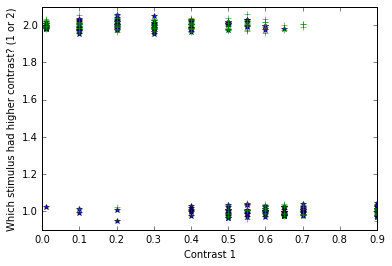

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(1)
# We apply a small vertical jitter to each point, just to show that there are
# multiple points at each location:

ax.plot(ortho['contrast1'], ortho['answer'] +
        np.random.randn(len(ortho)) * 0.02 , '*')
ax.plot(para['contrast1'], para['answer'] +
        np.random.randn(len(para)) * 0.02 , '+')
ax.set_ylim([0.9, 2.1])
ax.set_xlabel('Contrast 1')
ax.set_ylabel('Which stimulus had higher contrast? (1 or 2)')

In [5]:
def transform_data(data):
    """
    Function that takes experimental data and gives us the dependent/independent
    variables for analysis

    Parameters
    ----------
    data : rec array
        The data with records: `contrast1`, `contrast2` and `answer`

    Returns
    -------
    x : The unique contrast differences.
    y : The proportion of '2' answers in each contrast difference
    n : The number of trials in each x,y condition
    """
    contrast1 = data['contrast1']
    answers = data['answer']

    x = np.unique(contrast1)
    y = []
    n = []

    for c in x:
        idx = np.where(contrast1 == c)
        n.append(float(len(idx[0])))
        answer1 = len(np.where(answers[idx] == 1)[0])
        y.append(answer1 / n[-1])

    return x,y,n


In [6]:
x_ortho, y_ortho, n_ortho = transform_data(ortho)
x_para, y_para, n_para = transform_data(para)

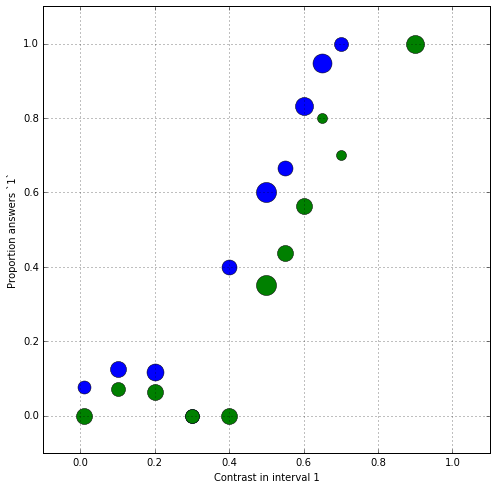

In [7]:
fig, ax = plt.subplots(1)
# To plot each point with size proportional to the number of trials in that condition:
for x,y,n in zip(x_ortho, y_ortho, n_ortho):
    ax.plot(x, y, 'bo', markersize=n)

for x,y,n in zip(x_para, y_para, n_para):
    ax.plot(x, y, 'go', markersize=n)

ax.set_xlabel('Contrast in interval 1')
ax.set_ylabel('Proportion answers `1`')
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])
ax.grid('on')
fig.set_size_inches([8,8])

# Linear Models

In [8]:
import numpy as np

In [9]:
beta1_ortho, beta0_ortho = np.polyfit(x_ortho, y_ortho, 1)
beta1_para, beta0_para = np.polyfit(x_para, y_para, 1)

* Reading the documentation of polyfit, you will learn that this function returns a tuple with the beta coefficient values, ordered from the highest degree to the lowest degree.

* That is, for the linear (degree=1) function we are fitting here, the slope is the first coeffiecient and the intercept of the function is the second coefficient in the tuple. To match the notation we used in our equations, we can assign as:

In [10]:
# this gives me predicted values of y_ortho given my x_ortho values
pred_ortho_y = np.polyval([beta1_ortho, beta0_ortho], x_ortho)

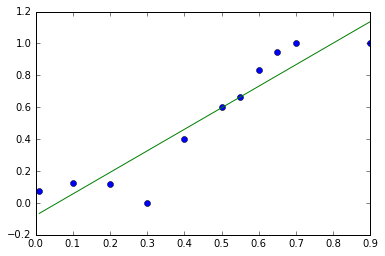

In [11]:
plt.plot(x_ortho, y_ortho, 'o')
plt.plot(x_ortho, pred_ortho_y)

In [12]:
pse_ortho = (0.5 - beta0_ortho)/beta1_ortho
pse_para = (0.5 - beta0_para)/beta1_para

In [13]:
pse_ortho

0.42841372022992219

# Evaluating Models

## calculate residuals by comparing prediction to actual value

In [14]:
np.sum((pred_ortho_y - y_ortho)**2) #Sum Square Error

0.20952711516781461

In [15]:
import scipy
import scipy.optimize as opt

In [16]:
from scipy import special
def cumgauss(x, mu, sigma):
    """
    The cumulative Gaussian at x, for the distribution with mean mu and
    standard deviation sigma.

    Parameters
    ----------
    x : float or array
       The values of x over which to evaluate the cumulative Gaussian function

    mu : float
       The mean parameter. Determines the x value at which the y value is 0.5

    sigma : float
       The variance parameter. Determines the slope of the curve at the point of
       Deflection

    Returns
    -------

    Notes
    -----
    Based on:
    http://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution_function

    """
    return 0.5 * (1 + special.erf((x-mu)/(np.sqrt(2)*sigma)))

In [19]:
x = np.linspace(0,1,100)

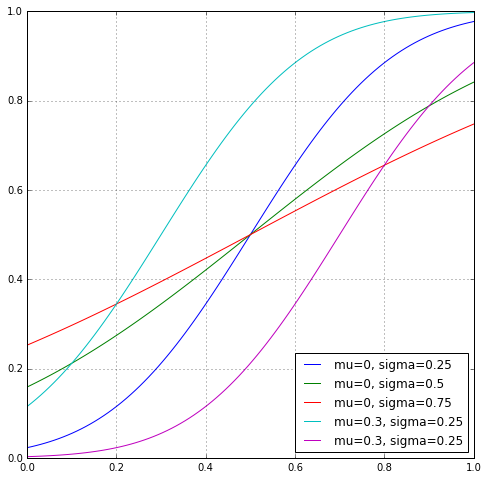

In [20]:
fig, ax = plt.subplots(1)
ax.plot(x, cumgauss(x, 0.5, 0.25), label='mu=0, sigma=0.25')
ax.plot(x, cumgauss(x, 0.5, 0.5), label='mu=0, sigma=0.5')
ax.plot(x, cumgauss(x, 0.5, 0.75), label='mu=0, sigma=0.75')
ax.plot(x, cumgauss(x, 0.3, 0.25), label='mu=0.3, sigma=0.25')
ax.plot(x, cumgauss(x, 0.7, 0.25), label='mu=0.3, sigma=0.25')
#ax.set_ylim([-0.1, 1.1])
#ax.set_xlim([-0.1, 1.1])
ax.grid('on')
fig.set_size_inches([8,8])
plt.legend(loc='lower right')

In [22]:
params_ortho, cov_ortho = opt.curve_fit(cumgauss, x_ortho, y_ortho)

In [24]:
fit_mu, fit_sigma = params_ortho

* Write the code that plots the model estimate and the actual data.
* Calculate the residuals and SSE of this model.
* What is the PSE of this model for both conditions (orthogonal and parallel)? Is this model better than the linear model?
    + PSE = point of subjective equality (psychophysics term)

In [25]:
y_fit = cumgauss(x_ortho, fit_mu, fit_sigma)

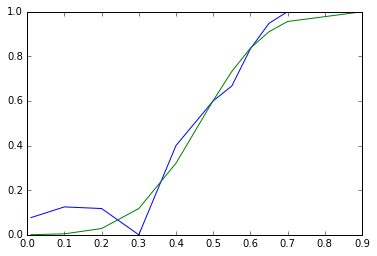

In [34]:
plt.plot(x_ortho, y_ortho)
plt.plot(x_ortho, y_fit)

In [32]:
sse_curve = np.sum((y_fit-y_ortho)**2)

In [35]:
sse_curve # sum of square error of our residuals

0.056134428101896935

* Here, mu is our PSE because it's a gaussian distribution

* Our SSE with the curve is __0.056__, compared to __0.2095__ with the linear model

# Model Evaluation with Cross Validation

### Try the Weibull function, which is often used in psychophysics 

In [36]:
def weibull(x, threshx, slope, lower_asymp, upper_asymp):
    """
    The Weibull cumulative distribution function

    Parameters
    ----------
    x : float or array
       The values of x over which to evaluate the cumulative Weibull function

    threshx : float
       The value of x at the deflection point of the function.
       For a lower_asymp set to 0.5, this is at approximately y=0.81  

    slope : float
        The slope of the function at the deflection point.

    lower_asymp : float
        The lower asymptote of the function

    upper_asymp : float
        The upper asymptote of the function.
    """
    threshy = 1 - (lower_asymp * np.exp(-1))
    k = (-np.log((1 - threshy) / (lower_asymp))) ** (1 / slope)
    m = (lower_asymp + upper_asymp - 1) * np.exp(-(k * x / threshx) ** slope)
    return upper_asymp - m


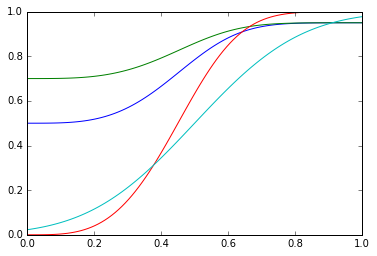

In [41]:
plt.plot(x, weibull(x, 0.5, 3.5, 0.5, 0.95))
plt.plot(x, weibull(x, 0.5, 3.5, 0.3, 0.95))
plt.plot(x, weibull(x, 0.5, 3.5, 1, 1))
plt.plot(x, cumgauss(x, 0.5, 0.25))

### Fit Weibull Function to Our Data

In [53]:
params_ortho_weibull, cov_ortho_weibull = opt.curve_fit(weibull, x_ortho, y_ortho)
# fit weibull models to get parameters

/Users/emilyhalket/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in power


In [54]:
threshx_fit, slope_fit, lower_asymp_fit, upper_asymp_fit = params_ortho_weibull
# unpack parameters from fit model to go into weibull function

In [55]:
y_fit_weibull = weibull(x_ortho, threshx_fit, slope_fit, lower_asymp_fit, upper_asymp_fit)
# using parameters get y_fit

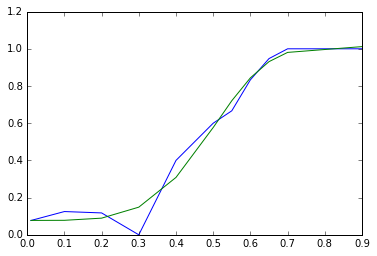

In [56]:
plt.plot(x_ortho, y_ortho)
plt.plot(x_ortho, y_fit_weibull)

In [57]:
np.sum((y_fit_weibull - y_ortho)**2) # calculate SSE for weibull

0.037834095001406963

### The Sum of Square Error (0.038)  is less than for the cumulative gauss function, but this model also has more parameters. Are we over fitting?
* we could use metrics (bayesian information criterion) to get an idea if we have too many parameters (they penalize parameters and reward low SSE)


* we can use cross validation to see if we are overfitting
    + could use k folds cross validation
    
    
* we are going to take every other trial and do 2-fold cross validation
    + don't want to just split in half in case subjects were just tired for second half

In [58]:
ortho_1 = ortho[::2] # takes every other item (even trials)
ortho_2 = ortho[1::2] # offset and take every other (odd trials)

In [60]:
x_ortho_1, y_ortho_1, n_ortho_1 = transform_data(ortho_1)
x_ortho_2, y_ortho_2, n_ortho_2 = transform_data(ortho_2)

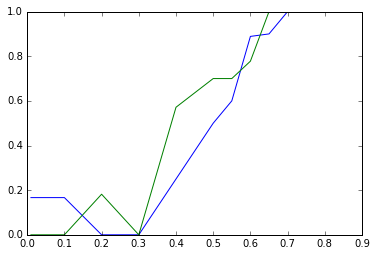

In [61]:
plt.plot(x_ortho_1, y_ortho_1)
plt.plot(x_ortho_2, y_ortho_2)

## fit cumulative gaussian

In [62]:
params_cg_ortho_1, cov_cg_ortho_1 = opt.curve_fit(cumgauss, x_ortho_1, y_ortho_1)
params_cg_ortho_2, cov_cg_ortho_2 = opt.curve_fit(cumgauss, x_ortho_2, y_ortho_2)

## fit weibull 

In [63]:
params_w_ortho_1, cov_w_ortho_1 = opt.curve_fit(weibull, x_ortho_1, y_ortho_1)
params_w_ortho_2, cov_w_ortho_2 = opt.curve_fit(weibull, x_ortho_2, y_ortho_2)

/Users/emilyhalket/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in power


## calculate the error by trying to predict half by using parameters from other half

In [64]:
pred_y_cg_ortho_1 = cumgauss(x_ortho_1, *params_cg_ortho_2) # * lets you use all parameters in that array
pred_y_cg_ortho_2 = cumgauss(x_ortho_2, *params_cg_ortho_1)

cg_sse = np.sum((pred_y_cg_ortho_1 - y_ortho_1)**2) + np.sum((pred_y_cg_ortho_2 - y_ortho_2)**2)

In [65]:
cg_sse

0.40954204718571818

In [68]:
pred_y_w_ortho_1 = weibull(x_ortho_1, *params_w_ortho_2) # * lets you use all parameters in that array
pred_y_w_ortho_2 = weibull(x_ortho_2, *params_w_ortho_1)

weibull_sse = np.sum((pred_y_w_ortho_1 - y_ortho_1)**2) + np.sum((pred_y_w_ortho_2 - y_ortho_2)**2)

In [69]:
weibull_sse

0.40973009108259628